# New York City Taxi Trip Duration

In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as

                    ϵ=√1n∑i=1n(log(pi+1)−log(ai+1))2
Where:

- ϵ is the RMSLE value (score)
- n is the total number of observations in the (public/private) data set,
- pi is your prediction of trip duration, and
- ai is the actual trip duration for ii. 
- log⁡(x) is the natural logarithm of x

#### Note
I decided to take part in this competition just to see how well i would perform. But i soon forget about it and only logged into my kaggle account after the competition ended. It allows for late submission though, so i was able to submit my predictions and get scored. 

In [62]:
#Let's read the training file
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv')

df.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,14/03/2016 17:24,14/03/2016 17:32,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,12/06/2016 00:43,12/06/2016 00:54,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,19/01/2016 11:35,19/01/2016 12:10,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,06/04/2016 19:32,06/04/2016 19:39,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,26/03/2016 13:30,26/03/2016 13:38,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,30/01/2016 22:01,30/01/2016 22:09,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,17/06/2016 22:34,17/06/2016 22:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,21/05/2016 07:54,21/05/2016 08:20,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,27/05/2016 23:12,27/05/2016 23:16,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,10/03/2016 21:45,10/03/2016 22:05,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [63]:
#Let drop columns that would not be useful at all in our learning

df.drop(labels = ['id', 'dropoff_datetime'], axis = 1, inplace = True)

df.dtypes

vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [64]:
#Let's now convert the object types to values that woul be useful for training
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df.store_and_fwd_flag = df.store_and_fwd_flag.map({'N': 0, 'Y': 1})


In [65]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.534503e+00,1.664382e+00,-7.397342e+01,4.075094e+01,-7.397336e+01,4.075183e+01,5.539899e-03,9.621448e+02
std,4.988084e-01,1.314261e+00,4.280165e-02,3.381389e-02,4.274282e-02,3.645002e-02,7.422408e-02,5.853002e+03
min,1.000000e+00,0.000000e+00,-7.854740e+01,3.435970e+01,-7.981798e+01,3.218114e+01,0.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399186e+01,4.073738e+01,-7.399131e+01,4.073594e+01,0.000000e+00,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075415e+01,-7.397973e+01,4.075455e+01,0.000000e+00,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396731e+01,4.076836e+01,-7.396301e+01,4.076984e+01,0.000000e+00,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.391176e+01,1.000000e+00,3.526282e+06


Looking at the statistical distribution above, we would assume that the trip duration (measured in seconds), should not be below 4 minutes and not above 2.5 hours. Also, a passenger should be in the taxi to be counted as a trip, so we would remove rows with passenger_count = 0.

In [66]:
df = df[df.passenger_count != 0]
df.drop(df[(df['trip_duration'] < 240) | (df['trip_duration'] > 9000)].index, inplace=True)
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,947126.000000,947126.000000,947126.000000,947126.000000,947126.000000,947126.000000,947126.000000,947126.000000
mean,1.534804,1.668709,-73.973284,40.750299,-73.973261,40.751210,0.005617,907.204869
std,0.498787,1.315041,0.043283,0.034079,0.043239,0.036946,0.074736,651.411163
min,1.000000,1.000000,-78.547401,34.359695,-79.817978,32.181141,0.000000,240.000000
25%,1.000000,1.000000,-73.992058,40.736736,-73.991409,40.734879,0.000000,466.000000
50%,2.000000,1.000000,-73.981956,40.753422,-73.979904,40.753979,0.000000,722.000000
75%,2.000000,2.000000,-73.967934,40.767696,-73.963272,40.768936,0.000000,1132.000000
max,2.000000,9.000000,-61.335529,51.881084,-61.335529,43.911762,1.000000,8899.000000


In [67]:
df.shape

(947126, 9)

### Detecting outliers

We would use a scatter plot to detect and remove outliers in the data

In [68]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

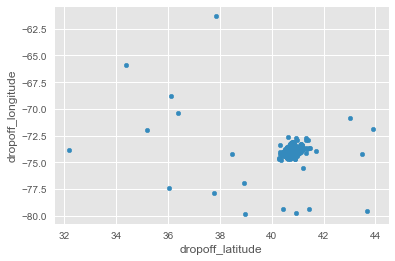

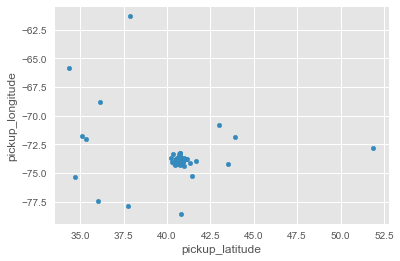

In [69]:

df.plot.scatter(x = 'dropoff_latitude', y = 'dropoff_longitude')
plt.xlabel('dropoff_latitude')
plt.ylabel('dropoff_longitude')
plt.show()

df.plot.scatter(x = 'pickup_latitude', y = 'pickup_longitude')
plt.xlabel('pickup_latitude')
plt.ylabel('pickup_longitude')

plt.show()

In [70]:
df.drop(df[(df['pickup_latitude'] < 40) | (df['pickup_latitude'] > 42.5)].index, inplace=True)
df.drop(df[(df['pickup_longitude'] < -75) | (df['pickup_longitude'] > -72.5)].index, inplace=True)
df.drop(df[(df['dropoff_longitude'] < -76) | (df['dropoff_longitude'] > -72)].index, inplace=True)
df.drop(df[(df['dropoff_latitude'] < 40) | (df['dropoff_latitude'] > 42)].index, inplace=True)

In [71]:
print(df.isnull().sum())

vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


No null values in the current dataset.
Now we create a correlation matrix to see how much correlation amongst columns there is.

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
vendor_id,1.000000,0.283970,0.019389,0.000947,0.006519,0.004437,-0.080587,0.007154
passenger_count,0.283970,1.000000,0.005322,-0.005859,0.000702,-0.002566,-0.021793,0.010989
pickup_longitude,0.019389,0.005322,1.000000,-0.166401,0.231121,0.037327,0.019901,0.388209
pickup_latitude,0.000947,-0.005859,-0.166401,1.000000,0.044355,0.383872,-0.009602,-0.235465
dropoff_longitude,0.006519,0.000702,0.231121,0.044355,1.000000,0.131259,0.015267,0.238389
dropoff_latitude,0.004437,-0.002566,0.037327,0.383872,0.131259,1.000000,-0.010138,-0.174867
store_and_fwd_flag,-0.080587,-0.021793,0.019901,-0.009602,0.015267,-0.010138,1.000000,0.029253
trip_duration,0.007154,0.010989,0.388209,-0.235465,0.238389,-0.174867,0.029253,1.000000


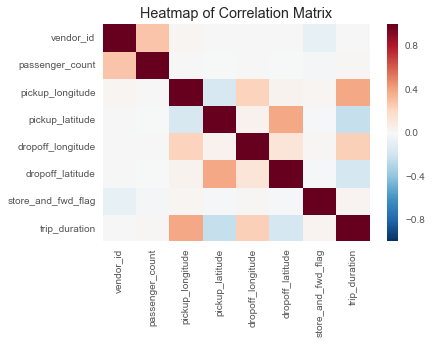

In [72]:
#Correlation Matrix
corr = df.corr()
corr = (corr)
sns.heatmap(corr,
xticklabels=corr.columns.values,
yticklabels=corr.columns.values)
sns.plt.title('Heatmap of Correlation Matrix')
corr

From this correletion matrix, we can see that 'vendor_id', 'passenger_count' and 'store_and_fwd_flag' have very little correlation with our target column - trip_duration. We can decide to remove thos columns, but let's first check the feature importances.

### Feature Engineering

We would create more features from the pickup_datetime column. This is enable better training on our dataset.

In [73]:
df['month'] = df.pickup_datetime.dt.month.astype(np.int8)
df['weekday'] = df.pickup_datetime.dt.weekday.astype(np.int8)
df['day'] = df.pickup_datetime.dt.dayofyear.astype(np.int8)
df['hour'] = df.pickup_datetime.dt.hour.astype(np.int8)
df['minute'] = df.pickup_datetime.dt.minute.astype(np.int8)

df.drop(labels = ['pickup_datetime'], axis = 1, inplace = True)
df.head(10)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,weekday,day,hour,minute
0,2,1,-73.982155,40.767937,-73.964630,40.765602,0,455,3,0,74,17,24
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,663,12,1,85,0,43
2,2,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,1,19,11,35
3,2,1,-74.010040,40.719971,-74.012268,40.706718,0,429,6,5,-100,19,32
4,2,1,-73.973053,40.793209,-73.972923,40.782520,0,435,3,5,86,13,30
5,2,6,-73.982857,40.742195,-73.992081,40.749184,0,443,1,5,30,22,1
6,1,4,-73.969017,40.757839,-73.957405,40.765896,0,341,6,4,-87,22,34
7,2,1,-73.969276,40.797779,-73.922470,40.760559,0,1551,5,5,-114,7,54
8,1,1,-73.999481,40.738400,-73.985786,40.732815,0,255,5,4,-108,23,12
9,2,1,-73.981049,40.744339,-73.973000,40.789989,0,1225,10,0,21,21,45


In [74]:
df.dtypes

vendor_id               int64
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag      int64
trip_duration           int64
month                    int8
weekday                  int8
day                      int8
hour                     int8
minute                   int8
dtype: object

### Prediction

In [75]:
y = df['trip_duration']
X = df.drop(labels=['trip_duration'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=275)

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [77]:
model = RandomForestRegressor(min_samples_leaf = 2, max_depth = 30, max_features = 'log2', n_estimators = 150)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
train_score = model.score(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)

print ("Score: ", round(score*100, 3))
print ("Training Score: ", round(train_score*100, 3))
print ("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print ("R2 Score: ", metrics.r2_score(y_test, y_pred))
print ("Mean Squared Error: ", metrics.mean_squared_error(y_test, y_pred))

Score:  74.835
Training Score:  89.962
Mean Absolute Error:  214.272091854
R2 Score:  0.748351936699
Mean Squared Error:  108310.387782


#### Feature Importance
To determine which of these features were most important to our training.

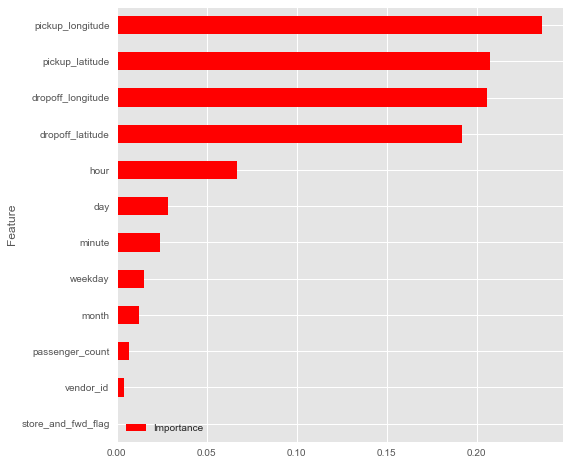

In [78]:

fimp = model.feature_importances_

importance_frame = pd.DataFrame({'Importance': list(fimp), 'Feature': list(X.columns)})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'red')
plt.show()

Now to experiment by removing the weaker feature importances and seeing if there would be an improvement in scores

In [79]:
new_df = df.drop(labels = ['vendor_id', 'passenger_count', 'store_and_fwd_flag'], axis = 1)

print(new_df.head(10))

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   
5        -73.982857        40.742195         -73.992081         40.749184   
6        -73.969017        40.757839         -73.957405         40.765896   
7        -73.969276        40.797779         -73.922470         40.760559   
8        -73.999481        40.738400         -73.985786         40.732815   
9        -73.981049        40.744339         -73.973000         40.789989   

   trip_duration  month  weekday  day  hour  minute  
0            455      3        0   74    17      24  
1            663     12        1   85     0 

In [80]:
new_y = new_df['trip_duration']
new_X = new_df.drop(labels=['trip_duration'], axis=1)

from sklearn.model_selection import train_test_split
newX_train, newX_test, newy_train, newy_test = train_test_split(new_X, new_y, test_size=0.25, random_state=275)

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [85]:
model2 = RandomForestRegressor(min_samples_leaf = 2, max_depth = 30, max_features = 'log2', n_estimators = 150)
model2.fit(newX_train, newy_train)
score = model2.score(newX_test, newy_test)
train_score = model2.score(newX_train, newy_train)

# make predictions for test data
newy_pred = model2.predict(newX_test)

print ("Test Score: ", round(score*100, 3))
print ("Training Score: ", round(train_score*100, 3))
print ("Mean Absolute Error: ", metrics.mean_absolute_error(newy_test, newy_pred))
print ("R2 Score: ", metrics.r2_score(newy_test, newy_pred))
print ("Mean Squared Error: ", metrics.mean_squared_error(newy_test, newy_pred))

Test Score:  76.018
Training Score:  91.16
Mean Absolute Error:  204.94093875
R2 Score:  0.760178183986
Mean Squared Error:  103220.321072


#### Root Mean Squared Logarithmic Error
The Root Mean Squared Logarithmic Error will now be used to score the power of this model.

In [86]:
from sklearn.metrics import make_scorer

def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [87]:
print('root mean squared logarithmic error: ', rmsle(y_pred, y_test))
print('root mean squared logarithmic error: ', rmsle(newy_pred, newy_test))

root mean squared logarithmic error:  0.332540439835
root mean squared logarithmic error:  0.314153114263


### Preparing Test File

Now we prepare the test file to test the model on it.

In [88]:
te = pd.read_csv('test.csv')

serial = te['id']
te_new = te.drop(labels = ['id', 'vendor_id', 'store_and_fwd_flag', 'passenger_count'], axis = 1)

In [89]:
te_new['pickup_datetime'] = pd.to_datetime(te_new['pickup_datetime'])

In [90]:
te_new.shape

(625134, 5)

In [91]:
#te_new['pickup_datetime'] = pd.to_datetime(te_new['pickup_datetime'])

te_new['month'] = te_new.pickup_datetime.dt.month.astype(np.int8)
te_new['weekday'] = te_new.pickup_datetime.dt.weekday.astype(np.int8)
te_new['day'] = te_new.pickup_datetime.dt.dayofyear.astype(np.int8)
te_new['hour'] = te_new.pickup_datetime.dt.hour.astype(np.int8)
te_new['minute'] = te_new.pickup_datetime.dt.minute.astype(np.int8)

te_new.drop(labels = ['pickup_datetime'], axis = 1, inplace = True)
te_new.head(10)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,weekday,day,hour,minute
0,-73.988129,40.732029,-73.990173,40.756680,6,3,-74,23,59
1,-73.964203,40.679993,-73.959808,40.655403,6,3,-74,23,59
2,-73.997437,40.737583,-73.986160,40.729523,6,3,-74,23,59
3,-73.956070,40.771900,-73.986427,40.730469,6,3,-74,23,59
4,-73.970215,40.761475,-73.961510,40.755890,6,3,-74,23,59
5,-73.991302,40.749798,-73.980515,40.786549,6,3,-74,23,59
6,-73.978310,40.741550,-73.952072,40.717003,6,3,-74,23,59
7,-74.012711,40.701527,-73.986481,40.719509,6,3,-74,23,59
8,-73.992332,40.730511,-73.875618,40.875214,6,3,-74,23,58
9,-73.993179,40.748760,-73.979309,40.761311,6,3,-74,23,58


In [92]:
te_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
pickup_longitude     625134 non-null float64
pickup_latitude      625134 non-null float64
dropoff_longitude    625134 non-null float64
dropoff_latitude     625134 non-null float64
month                625134 non-null int8
weekday              625134 non-null int8
day                  625134 non-null int8
hour                 625134 non-null int8
minute               625134 non-null int8
dtypes: float64(4), int8(5)
memory usage: 22.1 MB


In [93]:
#PREDICTION
prediction = model2.predict(pd.concat([te_new], axis = 1))

In [94]:
#CREATE SUBMISSION FILE
submission = pd.DataFrame({ 'id': serial, 'trip_duration': prediction })

submission.to_csv("submission__.csv", index=False)

### Conclusion

While the Root Mean Squared Logarithmic Error implemented here gives a score of - 0.314. The score for this prediction file from Kaggle is "0.54127" an improvement on the Mean Duration Benchmark of 0.89365.